## Offline analysis

here we will explore

In [1]:
import numpy as np
import matplotlib.pyplot as plt

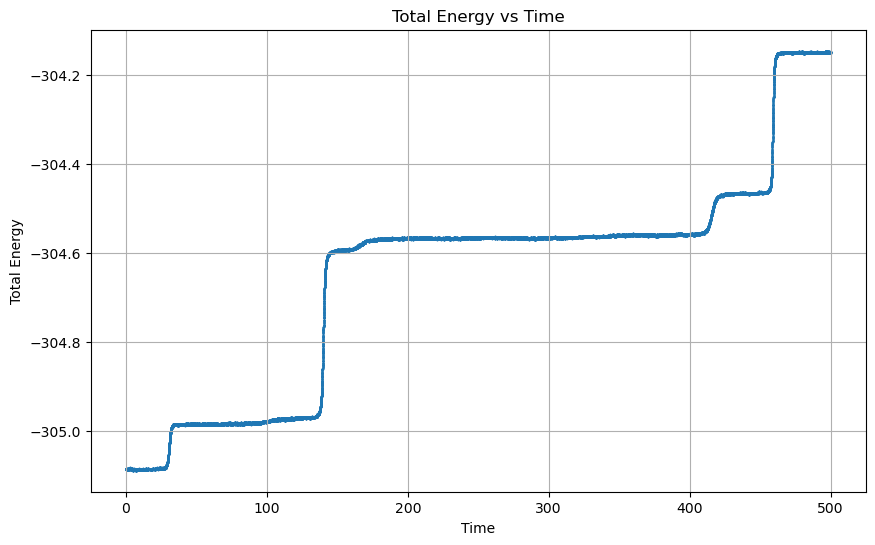

In [27]:
filename="../data/energy.txt"

data = np.loadtxt(filename)
time = data[:,0]
energy = data[:,3]
kinetic = data[:,1]
potential = data[:,2]


plt.figure(figsize=(10,6))
plt.scatter(time, energy, marker='.', s=0.8)
plt.xlabel("Time")
plt.ylabel("Total Energy")
plt.title("Total Energy vs Time")
plt.grid()
plt.show()